In [1]:
import os
import json
import networkx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './Tweets'
OUT_DIR = "./data/"
ALLOWED_CHARACTERS = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
                      'n','o','p','q','r','s','t','u','v','w','x','y','z',
                      '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '_']

In [3]:
df = pd.read_csv('users.csv')
seed_users = df['Usuário'].values
seed_users_orientation = df['Orientação Política'].values

In [4]:
def load_twint_json(text):
    tweets = []
    for tweet in text.split('\n'):
        if tweet != '':
            tweets.append(json.loads(tweet))

    return tweets

In [5]:
def get_who_user_retweeted(tweets):
    """Gets who user has retweeted on tweets
    
    Parameters
    ----------
    tweets : list
        List containing tweets formatted as dictionaries.
    
    Returns
    -------
    who_retweeted : list
        List of strings containing the username that a given user has retweeted.
    """
    who_retweeted = []
    for tweet in tweets:
        # For each tweet, check if it is a retweet
        if tweet['retweet']:
            # Try to find who user retweeted
            username_set = False
            try:
                # If it is in mentions, good...
                username = tweet['mentions'][0]['screen_name']
                username_set = True
            except IndexError:
                # If not, need to check the tweet text
                if 'RT' in tweet['tweet']:
                    username = []
                    # Gets mention. Initial position is the character after @
                    initial_pos = tweet['tweet'].find('@') + 1
                    # Sets flag
                    username_set = True
                    while True:
                        # Gets every character in the username
                        char = tweet['tweet'][initial_pos]
                        # While character is in the allowed characters, continue looping
                        # note that " " is not allowed, so we break after the mention finishes
                        if char.lower() in ALLOWED_CHARACTERS:
                            # if so, adds character to username and continue searching
                            username.append(char)
                            initial_pos += 1
                        else:
                            # otherwise, breaks
                            username_set = False
                            break
                    # joins the list of characters into a string
                    username = ''.join(username)
                else:
                    # If it is not a retweet, simply pass
                    pass
            if username_set:
                who_retweeted.append(username)
    return who_retweeted

In [6]:
def generate_adjacency_matrix(users, who_users_retweeted):
    """Aij => user i retweeted user j"""
    adjacency_matrix = np.zeros([len(users), len(users)])
    for user_i, who_user_retweeted in zip(users, who_users_retweeted):
        i = np.where(users == user_i)[0]
        for user_j in who_user_retweeted:
            if user_j in users:
                j = np.where(users == user_j)[0]
                adjacency_matrix[i, j] += 1

    return adjacency_matrix

In [7]:
def generate_standard_graph_json(users, degrees, orientations, adjacency_matrix):
    graph_json = {
        'nodes': [],
        'links': []
    }
    for i, (src_user, degree, orientation) in enumerate(zip(users, degrees, orientations)):
        graph_json['nodes'].append({
            'username': src_user,
            'Ideology': orientation,
            'degree': degree,
        })
        for j, tgt_user in enumerate(users):
            if adjacency_matrix[i, j] > 0:
                graph_json['links'].append({
                    'source': src_user,
                    'target': tgt_user,
                    'weight': A[i, j]
                })
                
    return graph_json

In [8]:
def generate_hierarchical_graph_json(users, degrees, orientations, adjacency_matrix):
    hierarchical_graph = []
    for i, (src_user, degree, orientation) in enumerate(zip(users, degrees, orientations)):
        hierarchical_graph.append({
            'name': "Orientation.{}.{}".format(orientation, src_user),
            'Ideology': orientation,
            'imports': []
        })
        for j, (tgt_user, orientation) in enumerate(zip(users, orientations)):
            if adjacency_matrix[i, j] > 0:
                hierarchical_graph[-1]['imports'].append("Orientation.{}.{}".format(orientation, tgt_user))
    
    return hierarchical_graph

In [9]:
searched_users = []
who_searched_users_retweeted = []
number_of_times_users_retweeted = []
print('-' * 43)
print("|{:^20}|{:^20}|".format("User", "Number of retweets"))
print('-' * 43)
total_retweets = 0
for file in os.listdir(DATA_DIR):
    user = file.split('.json')[0]
    with open(os.path.join(DATA_DIR, file), 'r') as f:
        data = f.read()

    tweets = load_twint_json(data)
    who_user_retweeted = get_who_user_retweeted(tweets)
    number_of_times_users_retweeted.append(len(who_user_retweeted))

    searched_users.append(user)
    who_searched_users_retweeted.append(who_user_retweeted)
    total_retweets += len(who_user_retweeted)
    print("|{:^20}|{:^20}|".format(user, len(who_user_retweeted)))
print("|{:^20}|{:^20}|".format("Total", total_retweets))
print('-' * 43)

-------------------------------------------
|        User        | Number of retweets |
-------------------------------------------
|   depbilacpinto    |         0          |
|  depjoaodanielpt   |        339         |
|   marceloramosam   |         21         |
|  slpng_giants_pt   |        421         |
|  DepFederalMoses   |         0          |
|  oficialigortimo   |         0          |
|   heldersalomao    |        462         |
|  DeputadoFederal   |        224         |
|   AlexisFonteyne   |         14         |
|     bulhoesjr      |         0          |
|  diegoescosteguy   |         5          |
|   depjorgesolla    |         93         |
|    pablovillaca    |        981         |
|    HeitorSchuch    |         5          |
|  JoeniaWapichana   |         26         |
|  LuisTibeOficial   |         1          |
|  FabioHenriqueSE   |         1          |
|     felipeneto     |        337         |
|      BohnGass      |        137         |
|     OsmarTerra     |        49

|   AfonsoFlorence   |        133         |
|      ZeSilva_      |         1          |
|    henrybugalho    |        100         |
|    RicardoIzar     |         29         |
|      renildo       |         3          |
|  DelegadoFreitas   |         3          |
|  alessandromolon   |        124         |
|  JulianLemosopb1   |         6          |
|      MBLivre       |        1584        |
|   HeitorFreireCE   |         1          |
|  CamiloSantanaCE   |         10         |
|   LuisMirandaUSA   |         14         |
|   eduardomoreira   |         61         |
|     pedropaulo     |         16         |
|     gilcutrim      |         1          |
|  VillaMarcovilla   |        116         |
|   mario_heringer   |         7          |
|    joseleonidas    |         6          |
|    DepJuscelino    |         78         |
|   maurocarlesse    |        147         |
|   PastorMalafaia   |         2          |
|   WladGarotinho    |         0          |
|    CelioStudart    |         4

|  jeronimogoergen   |         24         |
|    opropriolavo    |         89         |
|   fatimabezerra    |         66         |
|  OttoAlencarFilh   |         25         |
|    depHugoLeal     |         72         |
|  benesleocadiorn   |         0          |
|    revistaforum    |         4          |
|   GabrielaPrioli   |        140         |
|  CarlosBolsonaro   |         31         |
|   dep_acoutinho    |         3          |
|   AlineSleutjes    |         1          |
|    FMouraBrasil    |         99         |
|   AlexManente23    |         36         |
|  EdilazioJunior_   |         5          |
|    RenanFilho_     |         11         |
|    AleSerfiotis    |         0          |
|   FFrancischini_   |         0          |
|      J_LIVRES      |        315         |
|     ratinho_jr     |        180         |
|  jhonatan_djesus   |         0          |
|   perpetua_acre    |        273         |
|       safbf        |        209         |
|  CarlosZarattini   |        58

In [10]:
searched_users = np.array(searched_users)
ind_used_in_search = [np.where(seed_users == u)[0][0] for u in searched_users if u in seed_users]
searched_orientation = seed_users_orientation[ind_used_in_search]

who_searched_users_retweeted = np.array(who_searched_users_retweeted)
number_of_times_users_retweeted = np.array(number_of_times_users_retweeted)

A = generate_adjacency_matrix(searched_users, who_searched_users_retweeted).T
degrees = np.sum(A, axis=1)

/home/eduardo/.conda/envs/OptimalTransport/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


In [22]:
users_to_exclude = np.intersect1d(np.where(np.sum(A, axis=1) == 0)[0], np.where(np.sum(A, axis=0) == 0)[0])
ind_to_maintain = [i for i in range(len(searched_users)) if i not in users_to_exclude]
users_for_analysis = [searched_users[i] for i in range(len(searched_users)) if i not in users_to_exclude]
degrees_for_analysis = [degrees[i] for i in range(len(degrees)) if i not in users_to_exclude]
orientation_for_analysis = np.array([searched_orientation[i] for i in range(len(searched_orientation))
                                    if i not in users_to_exclude])
_A = A[ind_to_maintain, :][:, ind_to_maintain]

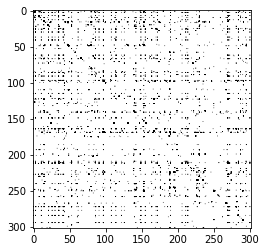

In [23]:
plt.imshow(_A, cmap='binary', vmin=0, vmax=1)

In [39]:
L = np.where(orientation_for_analysis == 'Esquerda')[0]
D = np.where(orientation_for_analysis == 'Direita')[0]
C = np.where(orientation_for_analysis == 'Centro')[0]

P = (np.sum(_A[L, :][:, D]) + np.sum(_A[L, :][:, C]) + np.sum(_A[D, :][:, L]) + np.sum(_A[D, :][:, C]) + \
     np.sum(_A[C, :][:, L]) + np.sum(_A[C, :][:, D]) ) / (6 * np.sum(_A))
Pleft = (
    np.sum(_A[L, :][:, D]) + np.sum(_A[L, :][:, C]) + np.sum(_A[D, :][:, L]) + np.sum(_A[C, :][:, L])
) / (4 * np.sum(_A[L, :]))
Pright = (
    np.sum(_A[D, :][:, C]) + np.sum(_A[D, :][:, L]) + np.sum(_A[L, :][:, D]) + np.sum(_A[C, :][:, D])
) / (4 * np.sum(_A[D, :]))
Pcenter = (
    np.sum(_A[C, :][:, D]) + np.sum(_A[C, :][:, L]) + np.sum(_A[D, :][:, C]) + np.sum(_A[L, :][:, C])
) / (4 * np.sum(_A[C, :]))

print(P * 100)
print(Pleft * 100)
print(Pright * 100)
print(Pcenter * 100)

1.4388258668204832
2.487061529614721
3.4444444444444446
33.63723608445298


In [29]:
standard_graph = generate_standard_graph_json(users_for_analysis,
                                              degrees_for_analysis,
                                              orientation_for_analysis, _A)

with open(os.path.join(OUT_DIR, 'standard_graph.json'), 'w') as f:
    f.write(json.dumps(standard_graph))

In [30]:
hierarchical_graph = generate_hierarchical_graph_json(users_for_analysis,
                                                      degrees_for_analysis,
                                                      orientation_for_analysis, _A)

with open(os.path.join(OUT_DIR, 'hierarchical_graph.json'), 'w') as f:
    f.write(json.dumps(hierarchical_graph))

In [46]:
retweet_json = []
for node_i in hierarchical_graph:
    retweet_json.append({'name': node_i['name'],
                         'Esquerda': 0,
                         'Centro': 0,
                         'Direita': 0})
    user_i = node_i['name'].split('.')[2]
    ideo_i = node_i['name'].split('.')[1]
    for node_j in node_i['imports']:
        user_j = node_j.split('.')[2]
        ideo_j = node_j.split('.')[1]
        retweet_json[-1][ideo_j] += 1

In [47]:
with open(os.path.join(OUT_DIR, 'retweet_statistics.json'), 'w') as f:
    f.write(json.dumps(retweet_json))